In [1]:
#pip install tsad

# Pipeline for the anomaly detection on the SKAB using LSTM-VAE

In [6]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
from io import StringIO
import requests
from tsad.evaluating.evaluating import evaluating


# Data loading

In [7]:
def dataframe_expirement(i):
    if i == 1:
        url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
        df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    else:
        url = "https://storage.yandexcloud.net/cloud-files-public/noname_ECG_2022.csv" 
        df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep=',')
    return df

In [32]:
df = dataframe_expirement(1)
df = df[df[df.columns[0]] == 'xxxAA564G']

df.replace(['-9999', -9999,'missing','#'], np.nan, inplace=True)
df = df[df['unitless'].notna()]
df = df[df['uR/h'].notna()]
df = df[df['ohmm'].notna()]
df_ = df.drop(axis=1, labels=(df.columns[0])) \
    .drop(axis=1, labels=(df.columns[1]))[['uR/h', 'unitless','ohmm']].reset_index(drop=True)

In [33]:
# ts_data_1, ts_data_2 = dataframe_expirement(1), dataframe_expirement(0).iloc[2500:].reset_index().drop(labels='index',axis=1)

In [34]:
ts_data_1 = df_

# Data description and visualization

In [35]:
from scipy.signal import find_peaks

In [36]:
def plot_data_scores_and_selected_window(ts, score_list, window_size_selected):
    f, ax = plt.subplots(2, 1, figsize=(30, 20))
    ax[0].plot(ts)
    ax[0].vlines(x=window_size_selected, ymin=min(ts), ymax=max(ts),
        linestyle = ':',
        linewidth = 6,
        color = 'darkblue')
    ax[0].set_title("ts")
    ax[1].plot(score_list, "r")
    ax[1].set_title("score")
    f.show()

In [37]:
# dataset characteristics printing
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
# print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
cp_1 = []
temp_value_second = 0
for i in range(len(ts_data_1)):
    temp_value = ts_data_1['unitless'][i]
    if temp_value != temp_value_second:
        cp_1.append(1)
    else:
        cp_1.append(0)
    temp_value_second = temp_value
cp_1[0] = 0
# cp_2 = []
# peaks, _ = find_peaks(ts_data_2['EcgWaveform'], distance=250)
# for i in range(len(ts_data_2)):
#     if i not in peaks:
#         cp_2.append(0)
#     else:
#         cp_2.append(1)
ts_data_1['change_points'] = cp_1
# ts_data_2['change_points'] = cp_2
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
# print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
n_cp_1 = cp_1.count(1)
# n_cp_2 = cp_2.count(1)
print(f'A number of changepoints in the well dataset: {n_cp_1}\n')
# print(f'A number of changepoints in the medical dataset: {n_cp_2}\n')
print(f'Head of the well dataset:')
display(ts_data_1.head())
# print(f'Head of the well dataset:')
# display(ts_data_2.head())

A number of datasets: 2

Shape of the well dataset: (8754, 3)

A number of datasets: 2

Shape of the well dataset: (8754, 4)

A number of changepoints in the well dataset: 52

Head of the well dataset:


,uR/h,unitless,ohmm,change_points
0,56.50,5.0,38.11802,0
1,55.10,5.0,38.51000,0
2,55.30,5.0,38.49500,0
3,55.50,5.0,38.48000,0
4,55.21,5.0,37.06394,0


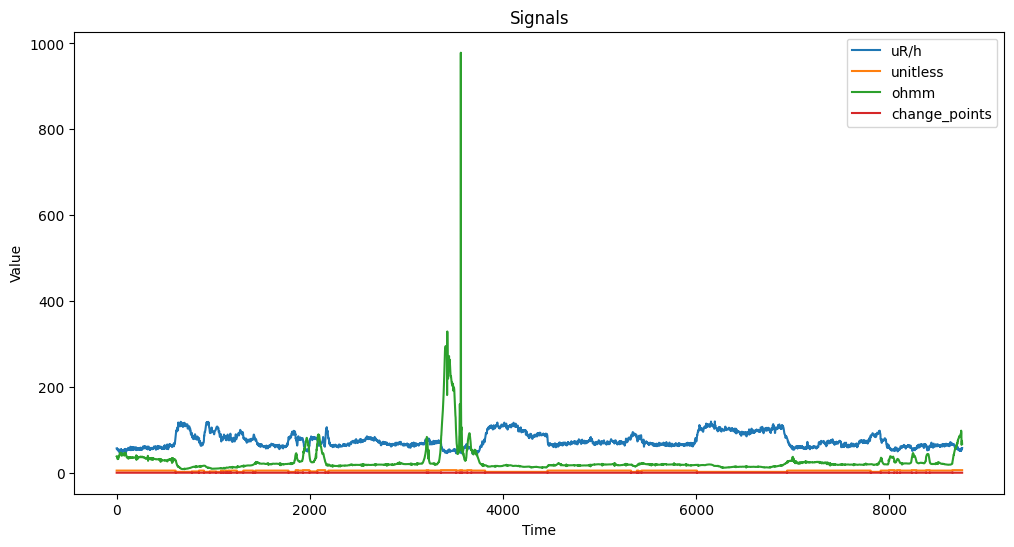

In [38]:
# well dataset visualizing
ts_data_1.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

In [39]:
# # medical dataset visualizing
# ts_data_2.plot(figsize=(12,6))
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Signals')
# plt.show()

In [40]:
# list_of_df = [ts_data_1[['change_points','uR/h','ohmm']], ts_data_2.drop('Time', axis=1)]
list_of_df = ts_data_1

# Method applying

In [41]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np

from scipy.signal import medfilt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [42]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [43]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        mse = losses.MeanSquaredError()
        xent_loss = mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

In [44]:
def arch(data):
    Random(0)
    
    input_dim = data.shape[-1] # 13
    timesteps = data.shape[1] # 3
    BATCH_SIZE = 1
    
    model, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=BATCH_SIZE, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

    history = model.fit(
        data,
        data,
        epochs=20,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return history, model

In [45]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [46]:
# hyperparameters selection
N_STEPS = 5
Q = 0.999 # quantile for upper control limit (UCL) selection

# inference
predicted_outlier, predicted_cp = [], []
# for df in tqdm(list_of_df, desc='1st loop'):
X_train = df_[:400].drop(['change_points'], axis=1)

# scaler init and fitting
StSc = StandardScaler()
StSc.fit(X_train)

# convert into input/output
X = create_sequences(StSc.transform(X_train), N_STEPS)

# model defining and fitting
history, model = arch(X)

# results predicting
residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
UCL = residuals.quantile(Q)

# results predicting
X = create_sequences(StSc.transform(df_.drop(['change_points'], axis=1)), N_STEPS)
cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data = cnn_residuals > (3/2 * UCL)
anomalous_data_indices = []
for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
    if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

prediction = pd.Series(data=0, index=df_.index)
prediction.iloc[anomalous_data_indices] = 1

# predicted outliers saving
predicted_outlier.append(prediction)

# predicted CPs saving
prediction_cp = abs(prediction.diff())
prediction_cp[0] = prediction[0]
predicted_cp.append(prediction_cp)

2023-04-03 16:47:12.266148: W tensorflow/c/c_api.cc:300] Operation '{name:'training_2/RMSprop/lstm_4/lstm_cell_4/kernel/rms/Assign' id:3827 op device:{requested: '', assigned: ''} def:{{{node training_2/RMSprop/lstm_4/lstm_cell_4/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/RMSprop/lstm_4/lstm_cell_4/kernel/rms, training_2/RMSprop/lstm_4/lstm_cell_4/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-04-03 16:47:13.662323: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:3335 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/lstm_5_loss/value)}}' was changed by setting attribute after it was run by a session.

# Results

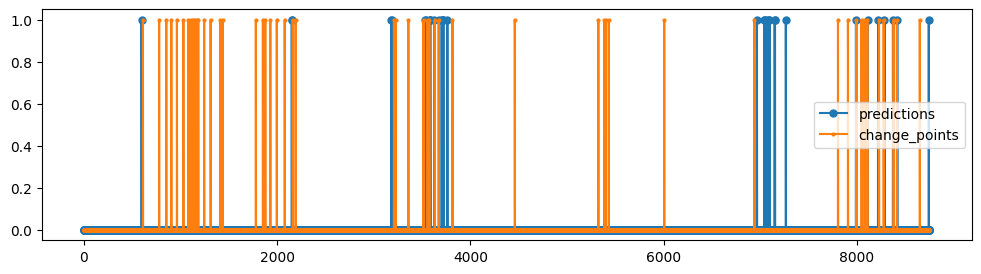

In [47]:
# true changepoint indices selection
true_cp = df_.change_points

predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp.plot(marker='o', markersize=2)
plt.legend();


In [50]:
predicted_cp[0] = [int(i) for i in predicted_cp[0]]

In [51]:
# # true changepoint indices selection
# true_cp = [df.change_points for df in list_of_df]

# predicted_cp[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
# true_cp[1].plot(marker='o', markersize=2)
# plt.legend();

# Metrics calculation

In [52]:
from datetime import datetime, timedelta

In [53]:
t_0 = np.arange(len(true_cp)).astype('datetime64[s]')
df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
df_0['predicted_cp'] = np.array(predicted_cp[0])
df_0['true_cp'] = np.array(true_cp)

In [54]:
# nab metric calculation
nab = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='nab', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


In [55]:
# average detection delay metric calculation
add = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='average_time', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


# 2023 NIR Results

In [56]:
def f1_evaluation(df):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(df['true_cp'], df['predicted_cp'], metric='average_time', numenta_time='30 sec')
    TP = true_anomalies - missed_cp
    if TP == 0:
        F1 = 0
        precision = 0
        recall = 0
    else:
        precision = TP/(TP+FPs)
        recall = TP/(TP+missed_cp)
        F1 =  2*precision*recall/(precision+recall)
    return F1, precision, recall

In [57]:
f1_evaluation(df_0)

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


(0.1904761904761905, 0.25, 0.15384615384615385)